In [5]:
import h5py
import glob
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import matplotlib

In [2]:
df = pd.read_csv("../BraTS20 Training Metadata.csv")
file_name = df['slice_path'].apply(lambda path: path.split("/")[-1])
target = df['target']

mapping = []

for f, t in zip(file_name, target):
    mapping.append((f, t))

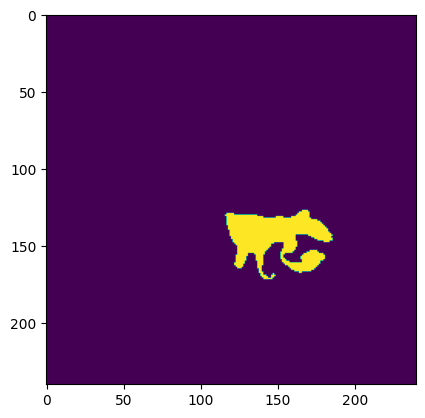

In [3]:
idx = np.random.randint(len(mapping))
image_file = os.path.join("../data", mapping[idx][0])

with h5py.File(image_file, "r") as file:
    image = np.array(file['image'])
    mask = np.array(file['mask'])

    layer0 = mask[:, :, 0]
    layer1 = mask[:, :, 1]
    layer2 = mask[:, :, 2]
    layer0[np.where(layer0 > 0)] = 50
    layer1[np.where(layer1 > 0)] = 100
    layer2[np.where(layer2 > 0)] = 200

    final_mask = np.zeros_like(layer0)

    for i in range(240):
        for j in range(240):
            if layer2[i][j] > 0:
                final_mask[i][j] = layer2[i][j]

    for i in range(240):
        for j in range(240):
            if layer1[i][j] > 0:
                final_mask[i][j] = layer1[i][j]
    
    for i in range(240):
        for j in range(240):
            if layer0[i][j] > 0:
                final_mask[i][j] = layer0[i][j] 

    plt.imshow(final_mask)
    plt.show()

In [4]:
idx = np.random.randint(len(mapping))
image_save_path = "../images"
mask_save_path = "../mask"

for idx, (image_name, label) in enumerate(mapping):
    image_file = os.path.join("../data", image_name)
    with h5py.File(image_file, "r") as file:
        image = np.array(file['image'])
        mask = np.array(file['mask'])
        
        # plt.figure(figsize=(16, 6))
        # plt.subplot(1, 4, 1)
        # plt.axis('off')
        # plt.imshow(image[:, :, 0], cmap="gray")

        # plt.subplot(1, 4, 2)
        # plt.axis('off')
        # plt.imshow(image[:, :, 1], cmap="gray")

        # plt.subplot(1, 4, 3)
        # plt.axis('off')
        # plt.imshow(image[:, :, 2], cmap="gray")

        # plt.subplot(1, 4, 4)
        # plt.axis('off')
        # plt.imshow(image[:, :, 3], cmap="gray")

        # plt.show()

        slice = image[:, :, 3]
        flatten_img = slice.flatten()

        no_zero = len(flatten_img[np.where(flatten_img > 0.0)])
        volume = no_zero / (slice.shape[0] * slice.shape[1])

        # print(label, volume)
        
        if volume >= 0.20:
            layer0 = mask[:, :, 0]
            layer1 = mask[:, :, 1]
            layer2 = mask[:, :, 2]
            layer0[np.where(layer0 > 0)] = 50
            layer1[np.where(layer1 > 0)] = 100
            layer2[np.where(layer2 > 0)] = 200

            final_mask = np.zeros_like(layer0)

            for i in range(240):
                for j in range(240):
                    if layer2[i][j] > 0:
                        final_mask[i][j] = layer2[i][j]
                    if layer1[i][j] > 0:
                        final_mask[i][j] = layer1[i][j]
                    if layer0[i][j] > 0:
                        final_mask[i][j] = layer0[i][j]


            saving_path = os.path.join(mask_save_path, f"{label}\{idx}.png")
            cropped_size = 25
            cropped_img = final_mask[cropped_size:-cropped_size, cropped_size:-cropped_size]
            matplotlib.image.imsave(saving_path, cropped_img)

            # break
        
        if idx % 100 == 0:
            print(f"{idx} done....")

0 done....
100 done....
200 done....
300 done....
400 done....
500 done....
600 done....
700 done....
800 done....
900 done....
1000 done....
1100 done....
1200 done....
1300 done....
1400 done....
1500 done....
1600 done....
1700 done....
1800 done....
1900 done....
2000 done....
2100 done....
2200 done....
2300 done....
2400 done....
2500 done....
2600 done....
2700 done....
2800 done....
2900 done....
3000 done....
3100 done....
3200 done....
3300 done....
3400 done....
3500 done....
3600 done....
3700 done....
3800 done....
3900 done....
4000 done....
4100 done....
4200 done....
4300 done....
4400 done....
4500 done....
4600 done....
4700 done....
4800 done....
4900 done....
5000 done....
5100 done....
5200 done....
5300 done....
5400 done....
5500 done....
5600 done....
5700 done....
5800 done....
5900 done....
6000 done....
6100 done....
6200 done....
6300 done....
6400 done....
6500 done....
6600 done....
6700 done....
6800 done....
6900 done....
7000 done....
7100 done....
7200

In [2]:
base_dir = "../splitted/train"

training_ds = []
train_class_0 = glob.glob(os.path.join(base_dir, "0/*"))
train_class_1 = glob.glob(os.path.join(base_dir, "1/*"))

for img in train_class_0:
    training_ds.append((img, 0))
    
for img in train_class_1:
    training_ds.append((img, 1))
    
len(training_ds)

34478

In [22]:
saving_path = "../splitted/train.hdf5"

with h5py.File(saving_path, "w") as hdf5_file:
    image_data = hdf5_file.create_dataset("images", (len(training_ds), 190, 190))
    image_label = hdf5_file.create_dataset("labels", len(training_ds), dtype='u1')
    
    # Write the images to the dataset
    for i, (img_path, label) in enumerate(training_ds):
        if i % 100 == 0:
            print(i, end="\r", flush=True)
        image_data[i] = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image_label[i] = int(label)
        # break

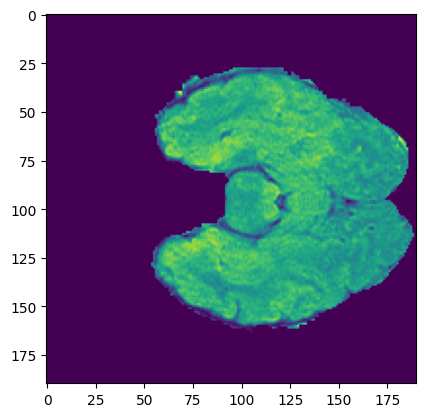

1.0


In [58]:
with h5py.File(saving_path, "r") as hdf5_file:
    image_data = hdf5_file["images"]
    image_label = hdf5_file["labels"]

    idx = np.random.randint(len(image_data))

    plt.imshow(image_data[idx])
    plt.show()
    print(image_label[idx])